Notebok prepared by Inês Gomes (ines.gomes@fe.up.pt)

based on Carlos Soares (csoares@fe.up.pt) tutorial.

Recommender Systems Libraries:
- for Rating Interactions: Surprise (https://surpriselib.com/)
- for Implicit Interactions: Implicit (https://github.com/benfred/implicit/tree/main)
- for an hybrid implementation: LightFM (https://making.lyst.com/lightfm/docs/index.html#)

## Table of Contents

1. [Dataset](#dataset)

2. [User-item Matrix](#matrix)

    2.1 [Pandas Version](#pandas)

    2.2 [Surprise Lib Version](#surprise)

3. [Recommender Systems](#recsys)

    3.1 [Popularity](#popularity)

    3.2 [Modelling](#modelling)

    3.3 [Top Recommendations](#top-rec)

In [25]:
import numpy as np
import pandas as pd
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
from surprise import accuracy
import random

In [26]:
import pandas as pd

# Sample dataframes
df1 = pd.DataFrame({'A': ['A0', 'A1', 'A2'],
                    'B': ['B0', 'B1', 'B2']})

df2 = pd.DataFrame({'X': ['X0', 'X1'],
                    'Y': ['Y0', 'Y1']})

# Performing a Cartesian product (cross-join)
result = df1.assign(key=1).merge(df2.assign(key=1), on='key').drop('key', axis=1)

print(result)

    A   B   X   Y
0  A0  B0  X0  Y0
1  A0  B0  X1  Y1
2  A1  B1  X0  Y0
3  A1  B1  X1  Y1
4  A2  B2  X0  Y0
5  A2  B2  X1  Y1


In [27]:
import matplotlib.pyplot as plt

## Dataset <a id="dataset"></a>

Jester dataset: https://eigentaste.berkeley.edu/dataset/

In [28]:
# Load data
from surprise import Dataset
from surprise import Reader

# Load the Jester5k data
data = Dataset.load_builtin('jester')

Our dataset is currently encapsulated in an object named "dataset" from the Surprise library.

In [29]:
data

We will transform the dataset into a pandas DataFrame in order to explore and visualize the data.

In [30]:
# transform the surprise dataset into pandas dataframe
df = pd.DataFrame(data.raw_ratings, columns=['user_id', 'item_id', 'rating', 'comments']).drop(columns=['comments'])

What can you tell about this dataset?

1. How many ratings do we have?

2. How many users do we have?

3. How many items do we have?

4. What is the distribution of ratings?

In [31]:
df.sample(10)

,user_id,item_id,rating
1660382,60310,15,8.844
108028,2824,60,6.750
504286,19162,108,1.094
1566060,56572,84,1.219
1367583,48651,128,8.719
947987,36671,122,9.156
1245338,45207,129,5.219
588890,23321,17,-6.031
706371,29704,126,-2.469
74442,1918,69,6.531


In [32]:
# TODO
len(df['rating'])

1761439

In [33]:
len(df['user_id'].unique())

59132

In [34]:
df["rating"].describe()

count    1.761439e+06
mean     1.618602e+00
std      5.302608e+00
min     -1.000000e+01
25%     -2.031000e+00
50%      2.219000e+00
75%      5.719000e+00
max      1.000000e+01
Name: rating, dtype: float64

<Axes: >

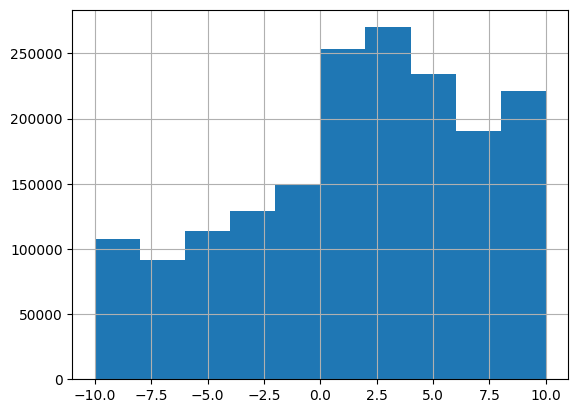

In [35]:
df["rating"].hist()

## User-item Matrix <a id="matrix"></a>

The first step to create a recommender system, is to transform the dataset into a user-item matrix. To that end, we must first define the "user", the "item" and the "value". The value can be a rating (explicit feedback) or binary information (implicit feedback).

In this case, our user is the column "user", the item is the "item" and the value is the "rating".

### Pandas version <a id="pandas"></a>

Let's create a user-item matrix based on our pandas dataframe.

In [36]:
# we will use the pivot function
df_matrix = df.pivot(index='user_id', columns='item_id', values='rating')

df_matrix

item_id,100,101,102,103,104,105,106,107,108,109,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,0.750,-5.000,2.938,2.000,-0.156,2.031,5.688,9.656,...,NaN,8.781,3.625,9.312,NaN,NaN,NaN,NaN,NaN,NaN
10,1.875,0.094,1.031,-1.031,2.219,0.219,5.406,4.844,3.281,-1.000,...,5.781,6.688,2.344,1.875,2.031,1.75,2.00,2.625,-2.312,2.125
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,6.125,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.969,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,NaN,NaN,NaN,NaN,3.062,5.562,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.312,NaN


Is this dataset sparse?

To calculate the sparsity, we count the number of ratings (that is, the number of cells in the matrix that are filled) and divide by the total number of user-item pairs. To count the number of users, we can simply count the number of rows in the matrix, while to count the number of items, we can simply count the number of columns. 

In [37]:
print(f"{df_matrix.notnull().sum().sum() / (df_matrix.shape[0] * df_matrix.shape[1]):.2%}")

21.28%


What is the:

1. distribution of total number of items per user?

2. distribution of total number of users per item?

3. distribution of mean ratings per user?

4. distribution of ratings?

(Show the histograms)

In [38]:
# TODO

### Surprise Library <a id="surprise"></a>

Now let's tranform dataset in a user-item matrix **using the surprise library**.

To that end, we can apply the method "build_full_trainset".

This is the documentation for the trainset object https://surprise.readthedocs.io/en/stable/trainset.html

(Using the trainset object is useful for applying the surprise library methods)

In [39]:
# Build the trainset
# THIS IS WRONG
trainset = data.build_full_trainset()

trainset

Explore the trainset object. 

Can you answer the same questions about the dataset using only the methods available in the trainset object? Do you have the same results?

In [40]:
# TODO

What are the two most popular items?

In [41]:
# TODO

## Recommender Systems <a id="recsys"></a>

In [42]:
# HACK: the dataset is too big, so we will pick or pandas dataframe, create a sample and then covert to the surprise lib dataset
reader = Reader(rating_scale=(df.rating.min(), df.rating.max()))
# you can try other sizes
size = 10000
data_sml = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']].sample(size), reader)

To properly evaluate the recommender systems, we will now split the original dataset into train and test. 

In [43]:
# use only the first half of the dataset as our dataset
# split intro train and test set
trainset, testset = train_test_split(data, test_size=0.2)

### Popularity <id a="popularity"></a>

The popularity method is the simplest recommender system.

It finds the most popular items and then recommends them to new users.

In [44]:
# Popular Recommender -> maybe we should use the rating too
def popular_recommendations(trainset, top_n=10):
    item_counts = defaultdict(int)

    # Iterate through the trainset to count item ratings
    for _, item_id, _ in trainset.all_ratings():
        item_counts[item_id] += 1

    # Sort items by popularity (number of ratings)
    popular_items = sorted(item_counts.items(), key=lambda x: x[1], reverse=True)

    # Get the top N most popular items (e.g., top 10)
    top_n = popular_items[:top_n]
    return [trainset.to_raw_iid(i) for i, _ in top_n]

These are the most popular items

In [45]:
popular_recommendations(trainset, 5)

['7', '8', '13', '15', '16']

### Modelling <a id="modelling"></a>

The predictor fills the matrix with the ratings por unseen user-item pairs.

To evaluate how good the model is, we calculate the RMSE between the true value and the predicted. 

As we are using the test set to create the predictions only for user-item pairs found in the test set.

In [46]:
# Define evaluation function
def evaluate_algorithm(algo, trainset, testset):
    algo.fit(trainset)
    predictions = algo.test(testset)
    
    # Compute and return RMSE
    rmse = accuracy.rmse(predictions)
    return rmse

In [47]:
# Random Recommender
random_algo = NormalPredictor()
random_rmse = evaluate_algorithm(random_algo, trainset, testset)

RMSE: 7.2704


In [48]:
# User-Based Collaborative Filtering
#ubcf_algo = KNNBasic(sim_options={'user_based': True})
#ubcf_rmse = evaluate_algorithm(ubcf_algo, trainset, testset)

In [49]:
# Item-Based Collaborative Filtering
ibcf_algo = KNNBasic(sim_options={'user_based': False})
ibcf_rmse = evaluate_algorithm(ibcf_algo, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 4.3345


In [50]:
# Singular Value Decomposition (SVD)
svd_algo = SVD()
svd_rmse = evaluate_algorithm(svd_algo, trainset, testset)

RMSE: 4.4963


In [51]:
print(f"Random RMSE: {random_rmse:.3f}")
#print(f"User-Based CF RMSE: {ubcf_rmse:.3f}")
print(f"Item-Based CF RMSE: {ibcf_rmse:.3f}")
print(f"SVD RMSE: {svd_rmse:.3f}")

Random RMSE: 7.270
Item-Based CF RMSE: 4.335
SVD RMSE: 4.496


### Top recommendations <a id="top-rec"></a>

The following function is designed to generate personalized recommendations for a user using a recommender model (`algo`) and a `Trainset` object. It uses the recommender model to make a rating prediction for each item the user hasn't interacted with and sorts the items by their estimated scores in descending order. Then, selects the top `n` items with the highest estimated scores as recommendations for the user.

In [52]:
# Recommend top N items for a user using a recommender model
def recommend_top_n(algo, trainset, user_id, n=10):
    user_ratings = trainset.ur[user_id]
    items = [item_id for (item_id, _) in user_ratings]
    
    item_scores = {}
    # this is actually not the most correct way to do this, but it works
    for item_id in trainset.all_items():
        if item_id not in items:
            prediction = algo.predict(trainset.to_raw_uid(user_id), trainset.to_raw_iid(item_id), verbose=True)
            item_scores[item_id] = prediction.est
    
    top_items = sorted(item_scores, key=item_scores.get, reverse=True)[:n]

    #from raw_id to actual_id
    return [trainset.to_raw_iid(i) for i in top_items]

In [53]:
# Get recommendations for a specific user using the User-Based CF model
user_id = 3 # Change to the desired user ID
ubcf_top_items = recommend_top_n(ibcf_algo, trainset, user_id , n=5)
print("Top 5 User-Based CF Recommendations for User", trainset.to_raw_uid(user_id), ":", ubcf_top_items)

user: 16875      item: 76         r_ui = None   est = 6.08   {'actual_k': 40, 'was_impossible': False}
user: 16875      item: 22         r_ui = None   est = 3.73   {'actual_k': 40, 'was_impossible': False}
user: 16875      item: 150        r_ui = None   est = 6.38   {'actual_k': 40, 'was_impossible': False}
user: 16875      item: 42         r_ui = None   est = 5.52   {'actual_k': 40, 'was_impossible': False}
user: 16875      item: 138        r_ui = None   est = 6.48   {'actual_k': 40, 'was_impossible': False}
user: 16875      item: 39         r_ui = None   est = 5.42   {'actual_k': 40, 'was_impossible': False}
user: 16875      item: 94         r_ui = None   est = 3.69   {'actual_k': 40, 'was_impossible': False}
user: 16875      item: 74         r_ui = None   est = 2.87   {'actual_k': 40, 'was_impossible': False}
user: 16875      item: 62         r_ui = None   est = 6.41   {'actual_k': 40, 'was_impossible': False}
user: 16875      item: 7          r_ui = None   est = 1.68   {'actual_k':

In [54]:
user_id = 10
n = 5
print("user_id", trainset.to_raw_uid(user_id))

print(recommend_top_n(ubcf_algo, trainset, user_id, n))
print(recommend_top_n(svd_algo, trainset, user_id, n))

user_id 52134


AttributeError: 'KNNBasic' object has no attribute 'sim'

How to evaluate this ranking?

In [ ]:
df_testset = pd.DataFrame(testset, columns=['user_id', 'item_id', 'rating'])

In [ ]:
df_testset.groupby("user_id").apply(len).value_counts()

1     8926
2     8386
3     6634
4     4955
5     3720
6     2989
7     2269
8     1885
9     1520
10    1213
11    1009
12     819
13     811
14     678
15     615
16     500
17     485
18     470
21     451
19     438
20     436
25     431
23     427
22     413
24     410
26     348
27     316
29     251
28     240
30     163
31     161
32     106
33      76
34      55
35      44
36      21
37      11
38       7
39       7
40       2
41       2
Name: count, dtype: int64

In [ ]:
# we just want to recommend positive ratings
pos_rating = 5
df_testset_pos = df_testset[df_testset["rating"] > pos_rating]
# which users exist in the training and testset
users = []
for u in df_testset_pos["user_id"].unique():
    try :
        trainset.to_inner_uid(u)
        users.append(u)
    except ValueError:
        continue

print("number of users in the testset that exist in the trainset:", len(users))

number of users in the testset that exist in the trainset: 28606


In [ ]:
random_user = random.choice(users)
n = 5
print("user_id : ", random_user)
gt = df_testset[(df_testset['user_id']==random_user) & (df_testset['rating']>pos_rating)].item_id.to_list()
print("ground truth : ", gt)
recs =  recommend_top_n(svd_algo, trainset, trainset.to_inner_uid(random_user), n)
print("recommendations: ",recs)
print(f"hits: {len(set(gt).intersection(set(recs)))} / {n}")

user_id :  60334
ground truth :  ['106', '68']
recommendations:  ['139', '99', '135', '91', '129']
hits: 0 / 5
